# Análisis de datos del COVID-19

Datos extraídos desde https://github.com/CSSEGISandData

<hr>

In [203]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import interact
py.offline.init_notebook_mode(connected=True)

In [204]:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

def complete_province(row):
    if type(row['Province/State'])==float:
        return row['Country/Region']
    else:
        return row['Province/State']

df_totales = df_confirmed.copy().loc[:, :'Long']
df_totales['Province/State'] =  df_totales.apply(lambda x: complete_province(x), axis=1)
df_totales['Confirmados'] = df_confirmed[df_confirmed.columns[len(df_confirmed.columns)-1]]
df_totales['Muertes'] = df_deaths[df_deaths.columns[len(df_deaths.columns)-1]]
df_totales['Recuperados'] = df_recovered[df_recovered.columns[len(df_recovered.columns)-1]]
df_totales['Activos'] = df_totales['Confirmados'] - (df_totales['Muertes'] + df_totales['Recuperados'])
df_totales['Text'] = '<b>'+df_totales['Country/Region']+'</b>, '+df_totales['Province/State'] +'<br>Confirmados: ' + df_totales['Confirmados'].map('{:,}'.format) \
+'<br>Muertes: ' +df_totales['Muertes'].map('{:,}'.format) \
+'<br>Recuperados: ' +df_totales['Recuperados'].map('{:,}'.format) \
+'<br>Activos: ' +df_totales['Activos'].map('{:,}'.format)

In [205]:
def get_marker_size(value):
    if value < 50:
        return 2
    if value > 50 and value < 200:
        return 3
    if value > 200 and value < 400:
        return 4
    if value > 400 and value < 800:
        return 5
    if value > 800 and value < 1600:
        return 6
    if value > 1600 and value < 3000:
        return 7
    if value > 50 and value < 200:
        return 3
    if value > 50 and value < 200:
        return 3
    if value > 50 and value < 200:
        return 3

In [206]:
def segment_df(name, kind, df):
    if kind == 'country':
        segmented_df = df[df['Country/Region']==country]
        if len(segmented_df) > 1:
            segmented_df = segmented_df.groupby('Country/Region').sum()
    elif kind == 'area':
        segmented_df = df[df['Province/State']==area]
        if len(segmented_df) > 1:
            segmented_df = segmented_df.groupby('Province/State').sum()
    return segmented_df
    

def get_series(country, kind, df):
    segmented_df = segment_df(country, kind, df)
    segmented_df = segmented_df.loc[:, '1/22/20':].T
    segmented_df = segmented_df[segmented_df>0].dropna()
    dates = [pd.to_datetime(fecha).strftime('%Y-%m-%d') for fecha in segmented_df.index]
    values = np.array([int(confirmed) for confirmed in segmented_df.values])
    return dates, values

<hr>

## Totales 

In [207]:
total_confirmed_series = df_confirmed.loc[:, '1/22/20':].sum(axis=0)
total_confirmed = total_confirmed_series[len(total_confirmed_series)-1]

total_deaths_series = df_deaths.loc[:, '1/22/20':].sum(axis=0)
total_deaths = total_deaths_series[len(total_deaths_series)-1]

total_recovered_series = df_recovered.loc[:, '1/22/20':].sum(axis=0)
total_recovered = total_recovered_series[len(total_recovered_series)-1]

active_cases_series = total_confirmed_series - (total_deaths_series + total_recovered_series)
total_active = active_cases_series[len(active_cases_series)-1]

print(f'Total confirmados: {total_confirmed}')
print(f'Total muertos: {total_deaths}')
print(f'Total recuperados: {total_recovered}')
print(f'Total casos activos: {total_active}')

Total confirmados: 272166
Total muertos: 11299
Total recuperados: 87256
Total casos activos: 173611


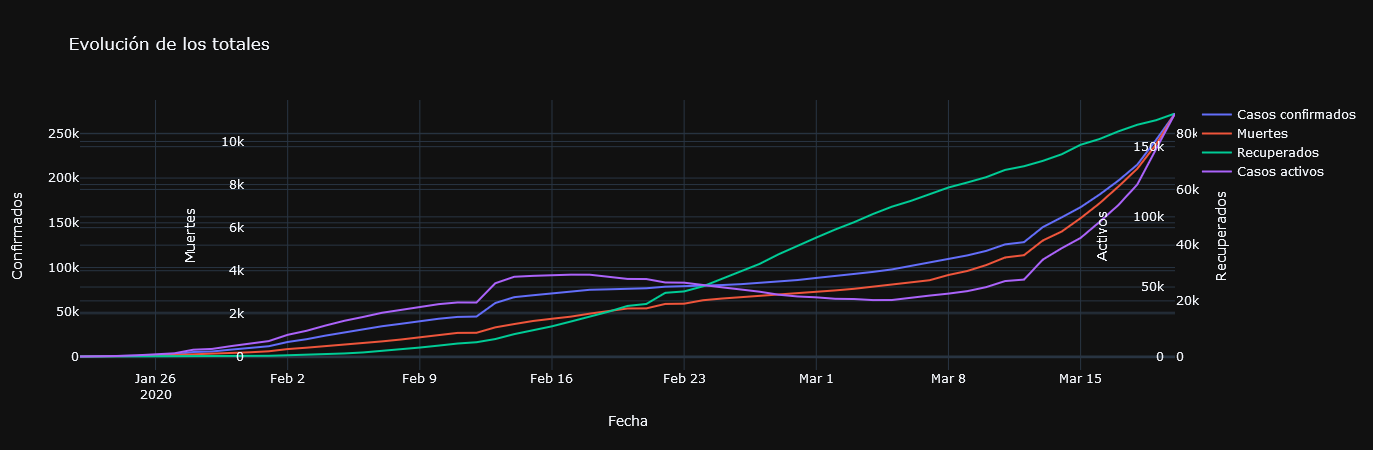

In [208]:
x_axis_values_confirmed = [pd.to_datetime(fecha).strftime('%Y-%m-%d') for fecha in total_confirmed_series.index]
x_axis_values_deaths = [pd.to_datetime(fecha).strftime('%Y-%m-%d') for fecha in total_deaths_series.index]
x_axis_values_recovered = [pd.to_datetime(fecha).strftime('%Y-%m-%d') for fecha in total_recovered_series.index]
x_axis_values_active = [pd.to_datetime(fecha).strftime('%Y-%m-%d') for fecha in active_cases_series.index]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x_axis_values_confirmed, 
        y=total_confirmed_series.values,
        name='Casos confirmados'
    )
)
fig.add_trace(
    go.Scatter(
        x=x_axis_values_deaths, 
        y=total_deaths_series.values,
        name='Muertes',
        yaxis='y2'
    )
)
fig.add_trace(
    go.Scatter(
        x=x_axis_values_recovered, 
        y=total_recovered_series.values,
        name='Recuperados',
        yaxis='y3'
    )
)
fig.add_trace(
    go.Scatter(
        x=x_axis_values_active,
        y=active_cases_series.values,
        name='Casos activos',
        yaxis='y4'
    )
)
fig.update_layout(
    title='Evolución de los totales',
    xaxis=dict(
        title='Fecha'
    ),
    yaxis=dict(
        title='Confirmados'
    ),
    yaxis2=dict(
        title='Muertes',
        anchor='free',
        overlaying='y',
        side='left',
        position=0.15,
        domain=[0.15, 1]
    ),
    yaxis3=dict(
        title='Recuperados',
        overlaying='y',
        side='right'
    ),
    yaxis4=dict(
        title='Activos',
        overlaying='y',
        side='left',
        position=0.99
    ),
    template='plotly_dark'
)
py.offline.iplot(fig)

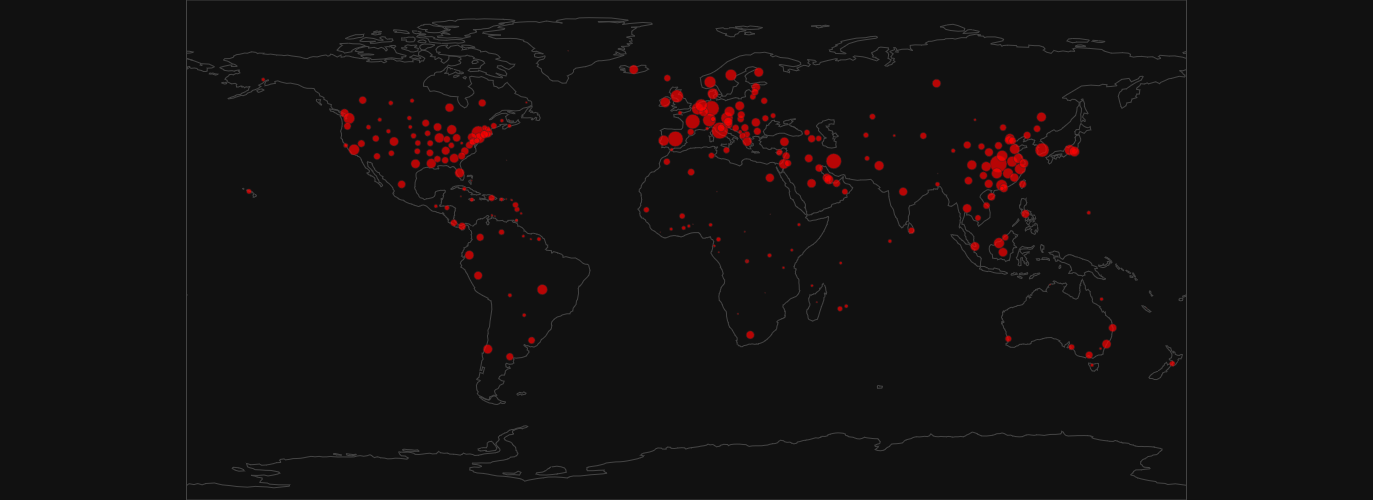

In [209]:
def get_marker_size(value):
    if value != 0:
        return np.log10(value**3)
    else:
        return value  

data=go.Scattergeo(
    lon = df_totales['Long'],
    lat = df_totales['Lat'],
    text=df_totales['Text'],
    marker = dict(
        color='red',
        sizeref = 2 * max(df_totales['Confirmados']) / (400 ** 2),
        size=df_totales['Confirmados'].apply(lambda x: get_marker_size(x)),
        line = go.scattergeo.marker.Line(
        width=0.5, color='rgb(40,40,40)'
        ),
        sizemode='diameter'
    ),
    hovertemplate='%{text}<extra></extra>',
    hoverlabel=dict(
        bgcolor = 'grey',
        bordercolor='black'
    ),
    hoverinfo='none'
)

layout=go.Layout(
    height=500, 
    margin={"r":0,"t":0,"l":0,"b":0},
    template='plotly_dark',
    title = 'Casos de COVID-19',
    geo_scope='world',
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

<hr>

## Datos para Europa

In [210]:
european_countrys = ['Italy', 'France', 'Spain', 'Germany']

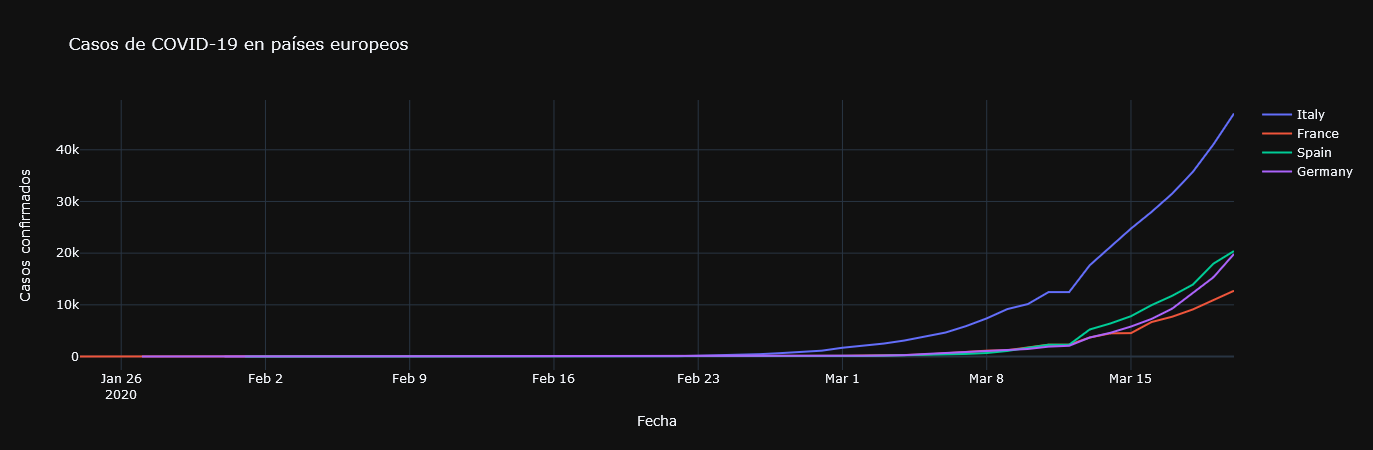

In [211]:
fig = go.Figure()
for country in european_countrys:
    dates_country, values_country = get_series(country, 'country', df_confirmed)
    fig.add_trace(go.Scatter(x=dates_country, y=values_country, name=country))
fig.update_layout(
    title='Casos de COVID-19 en países europeos',
    xaxis_title='Fecha',
    yaxis_title='Casos confirmados',
    template='plotly_dark'
)
py.offline.iplot(fig)

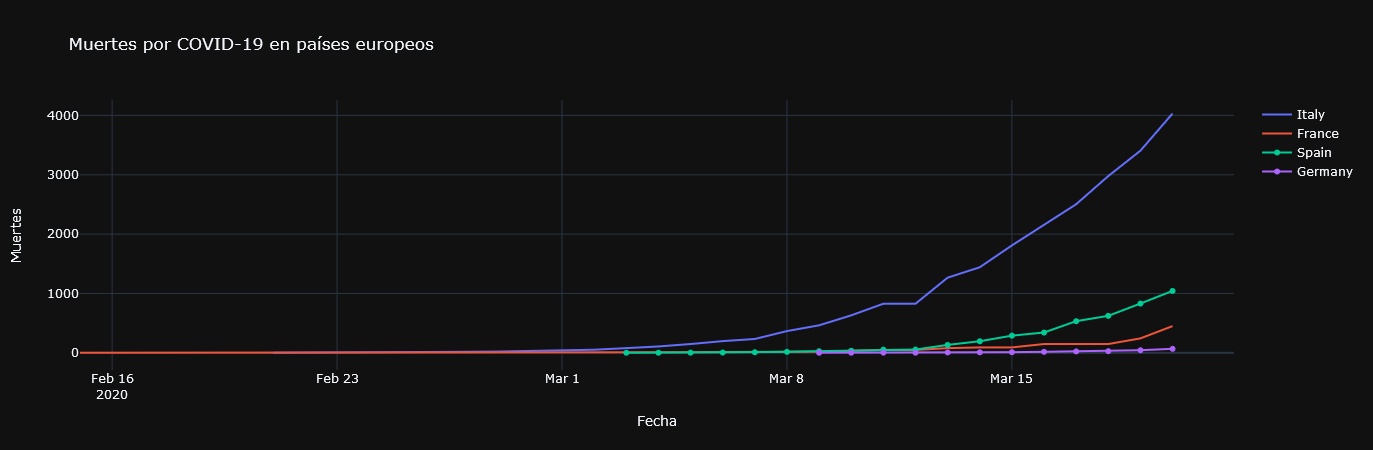

In [212]:
fig = go.Figure()
for country in european_countrys:
    dates_country, values_country = get_series(country, 'country', df_deaths)
    fig.add_trace(go.Scatter(x=dates_country, y=values_country, name=country))
fig.update_layout(
    title='Muertes por COVID-19 en países europeos',
    xaxis_title='Fecha',
    yaxis_title='Muertes',
    template='plotly_dark'
)
py.offline.iplot(fig)

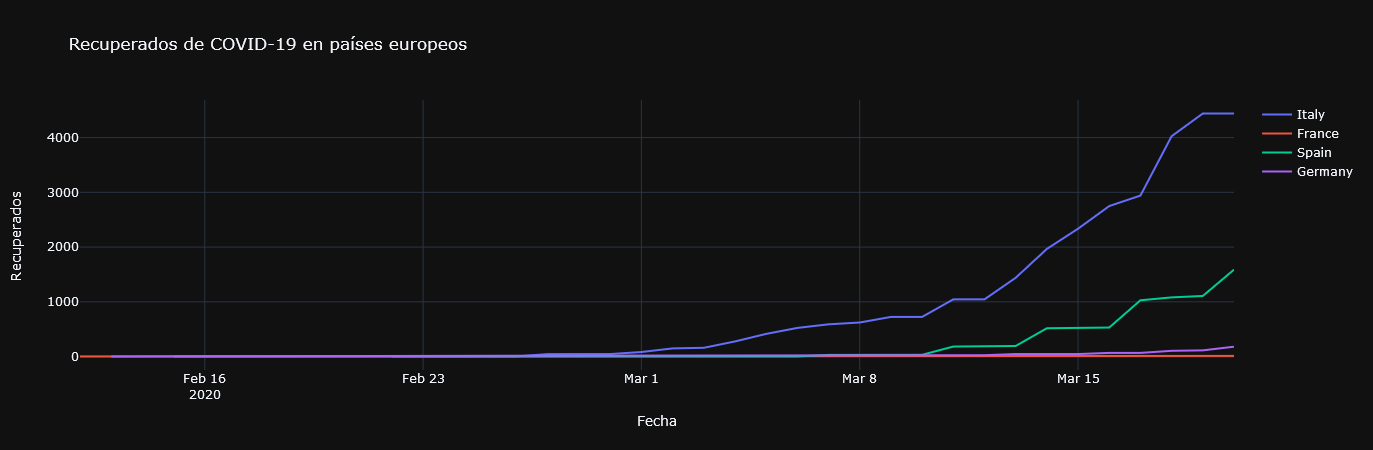

In [213]:
fig = go.Figure()
for country in european_countrys:
    dates_country, values_country = get_series(country, 'country', df_recovered)
    fig.add_trace(go.Scatter(x=dates_country, y=values_country, name=country))
fig.update_layout(
    title='Recuperados de COVID-19 en países europeos',
    xaxis_title='Fecha',
    yaxis_title='Recuperados',
    template='plotly_dark'
)
py.offline.iplot(fig)

<hr>

## Datos para América 

In [214]:
american_countrys = ['Brazil', 'Chile',  'Argentina', 'Peru', 'Ecuador', 'Venezuela']

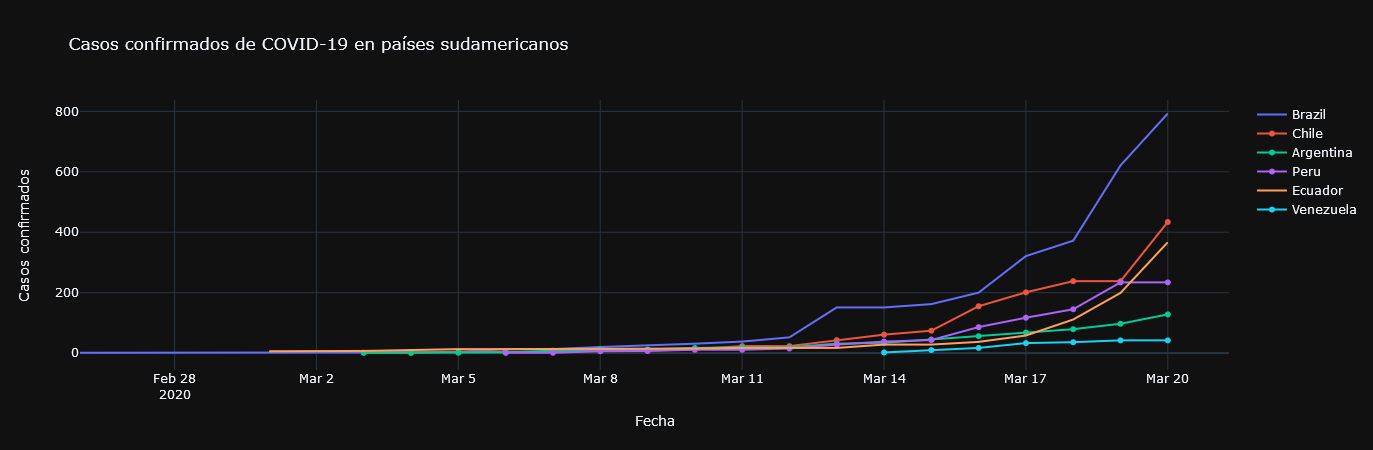

In [215]:
fig = go.Figure()
for country in american_countrys:
    dates_country, values_country = get_series(country, 'country', df_confirmed)
    fig.add_trace(go.Scatter(x=dates_country, y=values_country, name=country))
fig.update_layout(
    title='Casos confirmados de COVID-19 en países sudamericanos',
    xaxis_title='Fecha',
    yaxis_title='Casos confirmados',
    template='plotly_dark')
py.offline.iplot(fig)

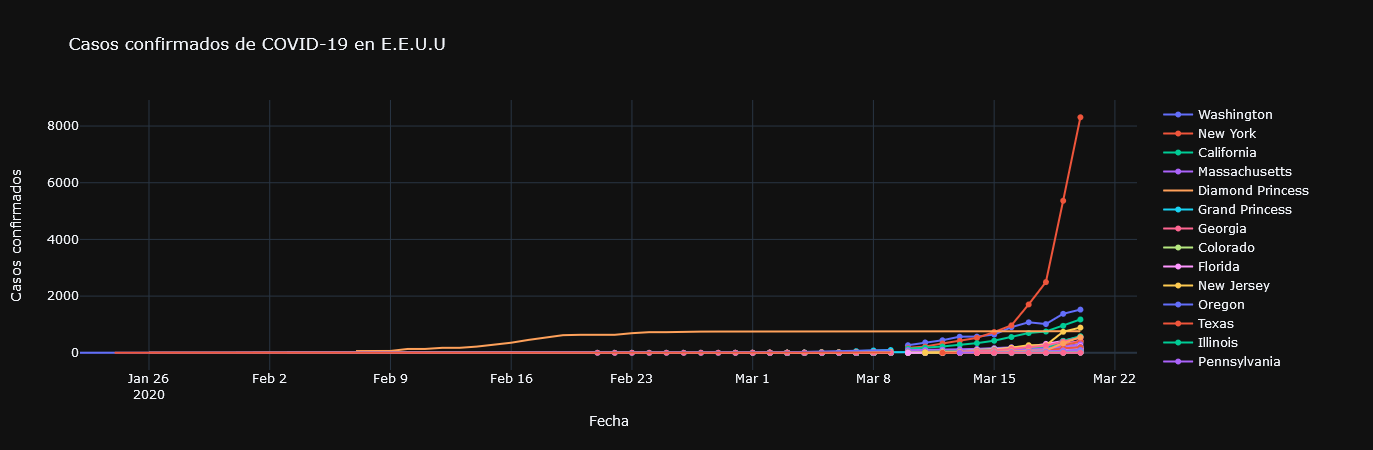

In [216]:
fig = go.Figure()
eeuu = df_confirmed[df_confirmed['Country/Region']=='US']
for area in eeuu['Province/State'].values:
    dates_area, values_area = get_series(area, 'area', df_confirmed)
    fig.add_trace(go.Scatter(x=dates_area, y=values_area, name=area))
fig.update_layout(
    title='Casos confirmados de COVID-19 en E.E.U.U',
    xaxis_title='Fecha',
    yaxis_title='Casos confirmados',
    template='plotly_dark')
py.offline.iplot(fig)

<hr>

## Datos para Asia 

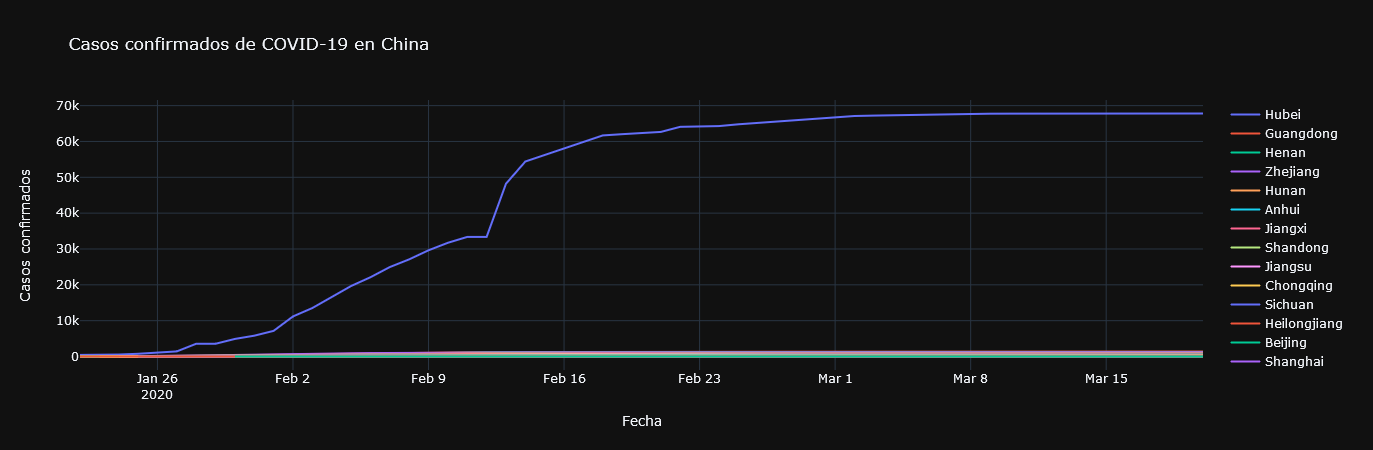

In [217]:
fig = go.Figure()
china = df_confirmed[df_confirmed['Country/Region']=='China']
for area in china['Province/State'].values:
    dates_area, values_area = get_series(area, 'area', df_confirmed)
    fig.add_trace(go.Scatter(x=dates_area, y=values_area, name=area))
fig.update_layout(
    title='Casos confirmados de COVID-19 en China',
    xaxis_title='Fecha',
    yaxis_title='Casos confirmados',
    template='plotly_dark')
py.offline.iplot(fig)

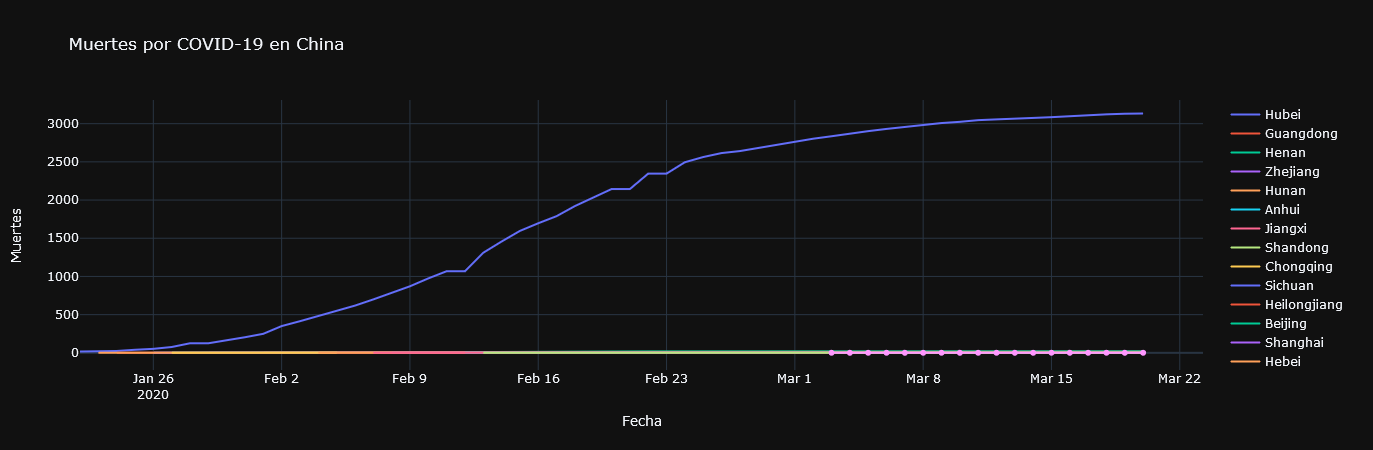

In [218]:
fig = go.Figure()
china = df_confirmed[df_confirmed['Country/Region']=='China']
for area in china['Province/State'].values:
    dates_area, values_area = get_series(area, 'area', df_deaths)
    fig.add_trace(go.Scatter(x=dates_area, y=values_area, name=area))
fig.update_layout(
    title='Muertes por COVID-19 en China',
    xaxis_title='Fecha',
    yaxis_title='Muertes',
    template='plotly_dark'
)
py.offline.iplot(fig)

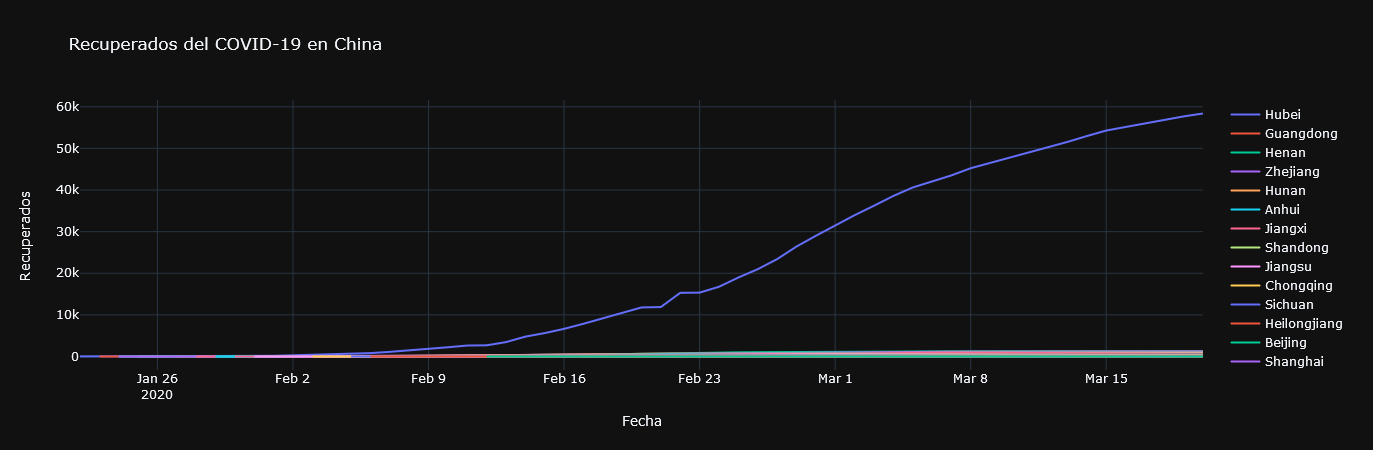

In [219]:
fig = go.Figure()
china = df_confirmed[df_confirmed['Country/Region']=='China']
for area in china['Province/State'].values:
    dates_area, values_area = get_series(area, 'area', df_recovered)
    fig.add_trace(go.Scatter(x=dates_area, y=values_area, name=area))
fig.update_layout(
    title='Recuperados del COVID-19 en China',
    xaxis_title='Fecha',
    yaxis_title='Recuperados',
    template='plotly_dark'
)
py.offline.iplot(fig)

In [220]:
china_confirmed = segment_df('China', 'country', df_confirmed)

In [221]:
china_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
421,NaN,Venezuela,6.4238,-66.5897,0,0,0,0,0,0,...,0,0,0,2,10,17,33,36,42,42


In [222]:
fig = go.Figure()
china = df_confirmed[df_confirmed['Country/Region']=='China']
for area in china['Province/State'].values:
    if area == 'Hubei':
        pass
    else:
        dates_area, values_area = get_active_cases(area, 'area')
        fig.add_trace(go.Scatter(x=dates_area, y=values_area, name=area))
fig.update_layout(
    title='Casos activos en China',
    xaxis_title='Fecha',
    yaxis_title='Casos activos',
    template='plotly_dark'
)
py.offline.iplot(fig)

NameError: name 'get_active_cases' is not defined